# Effortless models deployment with Mlflow

## The problem: Cats vs Dogs

In this problem, we have to write an algorithm to classify whether images contain either a dog or a cat. This is easy for humans, dogs, and cats, but your computer will find it a bit more difficult.

<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg' />

#### The Asirra data set
Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 
        

### Solving the problem

Let's start by getting some undestanding of the problem. This is what we know:

<ul>
    <li><b>Problem type:</b> Classification</li>
    <li><b>Number of classes:</b> 2 (cats, dogs)</li>
    <li><b>Input:</b> Images (25.000 — 50% cats, 50% dogs)</li>
</ul>

The dataset is completely balanced. 

## Introducing fast.ai

We are introducing here a framework called fast.ai (https://www.fast.ai/), a framework based on PyTorch with some handy operations already implemented to speed up problem solving quickly. To use fast.ai, we need to import 2 libraries: fastai and torch. fast.ai also has the named dataset already uploaded as part of the framework, which makes pretty convenient to work with it.

> Since fast.ai is a pretty unstable API (it changes very frequently), ensure you version is `fastai==2.4.1`. The `PyTorch` version I'm using is `torch==1.10`

Let's install all the requirements for this notebook:

In [ ]:
%pip install -r fastai-dogs-and-cats.txt --quiet

Importing some libraries

In [2]:
import torch
import fastai
import numpy as np
import pandas as pd

Since this is a computer vision problem, let's load some of the specific classes in FastAI for Computer Vision

In [3]:
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders

## Getting started

First things first, let's download and unzip the dataset. Please take into consideration that this dataset is a bit big.

In [4]:
path = untar_data(URLs.DOGS, dest="/tmp/.fastai")
image_files = get_image_files(path)
print('Data located at:', path)

Data located at: /tmp/.fastai/dogscats


As images are unzipped in a folder, we need to create a dataset to use for training and testing. `fast.ai` has a very simple way to do that. The method `ImageDataLoader.from_folder` creates a dataset of images located in a folder. THe folder itself has a pretty peculiar structure (imagenet format) where the data is already divided in trian/test and labels are inferred from the folder containing the image (folder cats contain `cats` and folder dogs contains `dogs`.

`batch_tfms` indicates which image transformations to apply in batches to all the images, while `item_tfms` indicate which transformations will be applied individually to each image. This is useful to construct transformation pipelines right into the data loader. The ds_tfms() method quickly gets a set of random transforms that have proved to work well in a wide range of tasks in computer vision, including a random flip is applied with probability 0.5, a random rotation, a random zoom, a random lightning and contrast change and a random symmetric warp.

Finally, the function normalize creates a normalize/denormalize func using an specific mean and std. In this case, those parameters are taken from the imagenet dataset, using the values imagenet_stats which are means = [0.485, 0.456, 0.406] and stds = [0.229, 0.224, 0.225].

In [5]:
data_loader = ImageDataLoaders.from_folder(path, item_tfms=Resize(224), batch_tfms=Normalize.from_stats(*imagenet_stats))

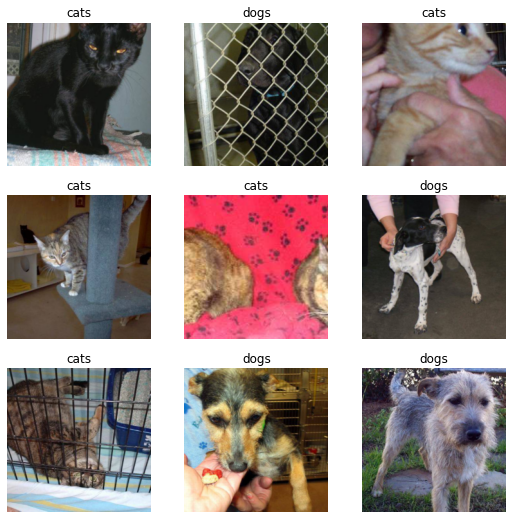

In [6]:
data_loader.train.show_batch()

### Creating a classifier based on ResNet34

#### Starting the mlflow experiment

Before starting, let's create a new experiemnt in Mlflow so we can track all the experimentation on it using Mlflow Tracking.

In [7]:
import mlflow

experiment_id = mlflow.set_experiment("mlflow-cats-vs-dogs")

Let's start the run

In [8]:
mlflow.start_run()

<ActiveRun: >

> **Note:** In general, we would run the training code in a `with` block using `with mlflow.start_run()`. This will ensure that everything in the with block is part of the run and hence mlflow will be able to track the time it takes to run the experiment. Since we are running this interactively in a notebook, we have to run the `start_run()` method at the beginning and `end_run()` at the end.

#### Designing a CNN
Once our dataset is ready, it's time to create our neural network. CNN represents a very convenient way to solve Computer Vision problems, specially when combined with transfer learning. We use transfer learning with a pretrained image classification models to extract visual features. The idea behind it is that the representations learned for task A (typically a high-level task) are applied to task B (typically a lower-level task) as for the degree of success at task B indicates how much the task A model has learned about task B.

In [9]:
learn = cnn_learner(data_loader, models.resnet34, metrics=accuracy)

Then it's time to train. When using transfer learning, the training process is a bit different like in a normal network. In the processes we take a pre-trained model and “fine-tuning” the model with your our own dataset. The idea is that this pre-trained model will act as a feature extractor. You will remove the last layer of the network and replace it with your own classifier. You then freeze the weights of all the other layers and train the network normally

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


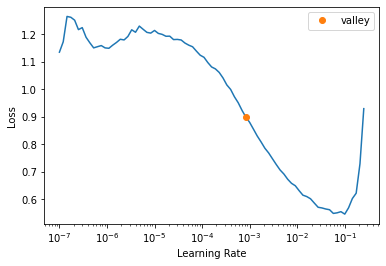

In [10]:
suggested_lr = learn.lr_find()

I'm using here the method `learn.lr_find()`. What this method does behind the scenes is running for few epochs to find out a good learning rate, where it trains from some low learning rate and increase the learning rate after each mini-batch till the loss value starts to explode. This single run provides valuable information on how well the network can be trained over a range of learning rates and what is the maximum learning rate. This is based on a paper https://arxiv.org/abs/1506.01186 which is a really good reading by the way. In Cyclical learning rates (CLR) one specifies minimum and maximum learning rate boundaries and a stepsize. The stepsize is the number of iterations (or epochs) used for each step and a cycle consists of two such steps – one in which the learning rate linearly increases from the minimum to the maximum and the other in which it linearly decreases.

We can then see which is the suggested learning rate by using the property `valley`. Let's use that to train our model.

In [11]:
learn.fine_tune(1, suggested_lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.098955,0.040605,0.985500,42:36


epoch,train_loss,valid_loss,accuracy,time
0,0.047642,0.025463,0.990500,1:10:08


> For simplicity, I'm only training for 1 epoch

### Testing the trained model

Let's see if the model works with an image

In [12]:
from fastai.vision.core import load_image

sample_img = load_image(image_files[1])
sample_img_arr = np.array(sample_img)

> Resizing the image is not required, as the model can do that in its trainsformation's pipeline. The reason why I do this is a bit bellow.

Running the model:

In [13]:
dl_model = learn.dls.test_dl([sample_img_arr])
real_preds, _ = learn.get_preds(dl=dl_model)

In [14]:
print(real_preds)

tensor([[1.0000e+00, 6.6361e-08]])


### Persisting the model

Once the model is trained, it's time to save the work. 

#### Saving the model in the Mlflow format

To save the model using Mlflow, we can call the function `mlflow.fastai.log_model`. However, before doing that we need to indicate the shape of the signature this model will accept. One way to do that is to use the infer_signature() method which will try to infer the signature from the given inputs and outputs of the model.

In [16]:
from mlflow.models.signature import infer_signature

In [17]:
signature = infer_signature(np.array([sample_img_arr]), real_preds.detach().numpy())

In [18]:
signature

inputs: 
  [Tensor('uint8', (-1, 479, 323, 3))]
outputs: 
  [Tensor('float32', (-1, 2))]

Another way to do that is to indicate the signature explicitly. I rather use this one cause inputs and outputs is something that you should really be aware of. So if they don't fit into your expectation, then an error will occur - meaning that you are missing something.

The model will take batches of images and will return the class probabilities of each class (in our case either cat or dog). This means that our inputs will be tensors of shape `(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)`. Since the model expects batches of images, the right input shape is `(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)`.

The schema then will be as follows:

In [19]:
import numpy as np
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

input_schema = Schema([
  TensorSpec(np.dtype(np.uint8), (-1, -1, -1, 3)),
])
output_schema = Schema([
  TensorSpec(np.dtype(np.float32), (-1, 2)),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

Some notes:

- **input_schema**: Our model can handle variable image sizes, since it has a transformation that resizes the image in the process (the `Resize(224)` transformation). Then, we can indicate a variable input size using -1 in `height` and `width`. The same applies to batch size, since we can handle variable sizes.

- **output_schema**: Our model will return class probabilities. Since we have 2 classes, then the out of the model has shape `(BATCH_SIZE, NUM_CLASSES)` or `(-1, 2)`.

Finally, we log the model like this:

In [20]:
model_info = mlflow.fastai.log_model(learn, "classifier", 
                                     registered_model_name="cats_vs_dogs",
                                     signature=signature)

Registered model 'cats_vs_dogs' already exists. Creating a new version of this model...
2022/03/16 04:33:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cats_vs_dogs, version 18
Created version '18' of model 'cats_vs_dogs'.


### Ending the experiment

Since we were running this experiment interactively in this notebook, we have to end it using:

In [21]:
mlflow.end_run()

## Deploying your model using mlflow

Now, let's see how we can deploy the model using Mlflow. Before doing that, it is always good to check that our model was persisted correctly and that it can be loaded. This will save us some time later in case something wrong happens.

Let's grab the URI of the model we just registered. 

In [22]:
serving_model_uri = model_info.model_uri
print(serving_model_uri)

runs:/879d0beb-0394-4b32-bd0f-8180512e9b44/classifier


That's the URI of the model inside the run (which we can totally deploy if we want to). However, I'm interested in deployed the model that ended registered in the Registry. This model will have a URI with the form `models:/cats_vs_dogs/1`.

In [23]:
serving_model_uri = 'models:/cats_vs_dogs/1'

### Loading the model just logged in MLFLow using the pyfunc flavor.

First, let's try to load the model using the `pyfunc` flavor into this notebook. We can use this method to check that the model can be loaded correctly.

In [24]:
mlflow_model = mlflow.pyfunc.load_model(serving_model_uri)

Let's create a simple batch to test it out:

In [25]:
sample_batch = sample_img_arr.reshape(1, sample_img.height, sample_img.width,3)

In [26]:
mlflow_model.predict(sample_batch)

,predictions
0,"[1.0, 2.9936704e-08]"


> Note how we use here the method `predict` to run the predictions. Compare this with the way we used to run the model before in the section [Testing the trained model](#Testing-the-trained-model)

### Running the model in a local server

We can run the model in an inference server locally in our local compute. Again, with this we can check that our deployment strategy will work. 

To do so, let's serve our model using mlflow:

```bash
mlflow models serve -m models:/cats_vs_dogs/1
```

Creating a sample request

In [27]:
import json

with open("sample.json", "w") as f:
    f.write(json.dumps(
        {
            "instances": sample_batch.tolist()
        }
    ))

Sending the request

In [28]:
!cat -A sample.json | curl http://127.0.0.1:5000/invocations \
                        --request POST \
                        --header 'Content-Type: application/json' \
                        --data-binary @-

[{"predictions": [1.0, 2.993641601278796e-08]}]

## Deploying the model to Azure ML

MLflow is integrated with several Machine Learning platforms, including Azure ML. We can deploy models created with MLFlow without changing any single implementation about them. They can be deployed to Azure Container Instances - ACI, Azure Kubernetes - AKS, or to Managed Endpoints - MIR.

To perform this operation, you have to have the plugin `azureml-mlflow` installed:

In [ ]:
%pip install azureml-mlflow==1.39.0

In [ ]:
import json
import mlflow
from mlflow.deployments import get_deploy_client

Create the deployment configuration. If no deployment configuration is provided, then the deployment happens on ACI.

In [ ]:
deploy_config = {
    "computeType": "aci",
    "containerResourceRequirements":
    {
        "cpu": 2,
        "memoryInGB": 4
    }
}

Write the deployment configuration into a file.

In [ ]:
deployment_config_path = "deployment_config.json"
with open(deployment_config_path, "w") as outfile:
    outfile.write(json.dumps(deploy_config))

Set the tracking uri as the deployment client. If you are running inside a Compute Instance in Azure ML, then you can use `mlflow.get_tracking_uri()`.

In [ ]:
client = get_deploy_client(mlflow.get_tracking_uri())

> If you are running outside an Azure ML compute, then you need to get the tracking URL of the workspace you are working on. To do so go to https://ml.azure.com, then click on the name of your workspace in the uper right corner, and click on View all properties in Azure Portal. There, copy the value of the property `MLflow tracking URI` and place it as paramter of `get_deploy_client` like this:

```python
client = get_deploy_client('azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/<GUID>/resourceGroups/<RESOURCE_GROUP>/providers/Microsoft.MachineLearningServices/workspaces/<WORKSPACE_NAME>')
```

MLflow requires the deployment configuration to be passed as a dictionary.

In [ ]:
config = {'deploy-config-file': deployment_config_path}
model_name = "cats_vs_dogs"
model_version = 1

Define the model path and the name is the service name. If model is not registered, it gets registered automatically and a name is autogenerated using the "name" parameter below

In [ ]:
client.create_deployment(model_uri=f'models:/{model_name}/{model_version}',
                        config=config,
                        name="cats-vs-dogs-aci-deployment")

After the model deployment completes, requests can be posted via HTTP to the new ACI webservice's scoring URI.

In [ ]:
print("Scoring URI is: %s", webservice.scoring_uri)